This tutorial demonstrates how to generate a particle_dataset in Relion using `cryojax`. This tutorial builds upon tools already shown in other tutorials, so we might skip over some details.

In [1]:
%load_ext autoreload
%autoreload 2

First we will do all the imports required to run the tutorial

In [1]:
# Jax and Equinox imports
from functools import partial

import equinox as eqx
import jax
import jax.numpy as jnp
from jaxtyping import PRNGKeyArray

In [2]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [ ]:
# CryoJAX imports

import cryojax.simulator as cxs
from cryojax.data import (
    RelionParticleParameterFile,
    RelionParticleStackDataset,
    simulate_particle_stack,
)
from cryojax.image import transforms as tf
from cryojax.io import read_atoms_from_pdb
from cryojax.rotations import SO3

# Generating a starfile

We have split this tutorial in two parts. In the first part we will generate a starfile, but we will not generate any particles. In the second part we will show how to generate particles from a starfile, and how to save such particles to the respective MRC Files.

We have decided to keep this two steps separate for a simple reason, flexibility. We want to make it possible for every user to design their own image formation pipeline. In some of our other tutorials we have showed how to generate noiseless image, images with solvent noise, or images with noise coming from a distribution. You can easily adapt this tutorial to those cases, or any other pipeline you build.

Now we will start by generating a starfile. To do this, we will first create a cryojax RelionParticleParameterDataset.

In this function we vmap over `jax` random keys. You can adapt this function to your needs, such as adapting the range of the distributions for the random parameters, or changing wheter a parameter is random or not.

In [ ]:
@partial(eqx.filter_vmap, in_axes=(0, None))
def make_particle_parameters(
    key: PRNGKeyArray, instrument_config: cxs.InstrumentConfig
):  # -> tuple[RelionParticleParameters, RelionParticleParameters]:
    # Generate random parameters

    # Pose
    # ... instantiate rotations
    key, subkey = jax.random.split(key)  # split the key to use for the next random number
    rotation = SO3.sample_uniform(subkey)

    # ... now in-plane translation
    ny, nx = instrument_config.shape

    key, subkey = jax.random.split(key)  # do this everytime you use a key!!
    offset_in_angstroms = (
        jax.random.uniform(subkey, (2,), minval=-0.2, maxval=0.2)
        * jnp.asarray((nx, ny))
        * instrument_config.pixel_size
    )
    # ... build the pose
    pose = cxs.EulerAnglePose.from_rotation_and_translation(rotation, offset_in_angstroms)

    # CTF Parameters
    # ... defocus
    key, subkey = jax.random.split(key)
    defocus_in_angstroms = jax.random.uniform(subkey, (), minval=10000, maxval=15000)

    key, subkey = jax.random.split(key)
    astigmatism_in_angstroms = jax.random.uniform(subkey, (), minval=0, maxval=100)

    key, subkey = jax.random.split(key)
    astigmatism_angle = jax.random.uniform(subkey, (), minval=0, maxval=jnp.pi)

    key, subkey = jax.random.split(key)
    phase_shift = jax.random.uniform(subkey, (), minval=0, maxval=0)
    # no more random numbers needed

    # now generate your non-random values
    spherical_aberration_in_mm = 2.7
    amplitude_contrast_ratio = 0.1

    # ... build the CTF
    transfer_theory = cxs.ContrastTransferTheory(
        ctf=cxs.CTF(
            defocus_in_angstroms=defocus_in_angstroms,
            astigmatism_in_angstroms=astigmatism_in_angstroms,
            astigmatism_angle=astigmatism_angle,
            spherical_aberration_in_mm=spherical_aberration_in_mm,
        ),
        amplitude_contrast_ratio=amplitude_contrast_ratio,
        phase_shift=phase_shift,
    )

    particle_parameters = {
        "instrument_config": instrument_config,
        "pose": pose,
        "transfer_theory": transfer_theory,
        "metadata": {},
    }

    return particle_parameters

In [6]:
# Generate instrument config
instrument_config = cxs.InstrumentConfig(
    shape=(128, 128),
    pixel_size=1.5,
    voltage_in_kilovolts=300.0,
    pad_scale=1.0,  # no padding
)

# Generate RNG keys
number_of_images = 100
keys = jax.random.split(jax.random.key(0), number_of_images)

# ... instantiate the RelionParticleParameterDataset
# particle_parameters_vmap, particle_parameters_novmap = make_particle_parameters(
#     keys, instrument_config
# )

particle_parameters = make_particle_parameters(keys, instrument_config)

Let's now create a starfile and add the newly created particle parameters

In [ ]:
# ... generate the starfile
new_parameters_file = RelionParticleParameterFile(
    path_to_starfile="./outputs/relion_dataset.star",
    mode="w",  # writing mode!
    exists_ok=True,  # in case the file already exists
)
new_parameters_file.append(particle_parameters)
new_parameters_file.save(overwrite=True)

# Simulating particles based on a starfile and writing them to mrcs

Now we will see how to define the functions required for our `write_simulated_image_stack_from_starfile` function to work.

First, let's load the starfile we generated in the previous step. We will also define some objects required to generate images.

## Simulating noiseless images

First, we will generate a stack without noise using one of `cryojax` imaging pipelines. Start by creating a `RelionParticleDataset` in writing mode.

In [ ]:
# First load the starfile
path_to_mrc_files = "./outputs/relion_dataset_particles/noiseless"

noiseless_particle_dataset = RelionParticleStackDataset(
    new_parameters_file,
    path_to_relion_project=path_to_mrc_files,
    mode="w",
    mrcfile_settings={"overwrite": True},  # customize your .mrcs !
)

!!! info "For more information on reading data in RELION, check our `Read a particle stack` tutorial."

Now let's define the structure we will use to generate images. In this case, we show how to load a pdb and then turn it into a voxel grid. We all need to define how we will integrate our potential.

In [9]:
from cryojax.constants import (
    get_tabulated_scattering_factor_parameters,
    read_peng_element_scattering_factor_parameter_table,
)


filename = "./data/groel_chainA.pdb"
atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    filename, center=True, select="not element H", loads_b_factors=True
)
scattering_factor_parameters = get_tabulated_scattering_factor_parameters(
    atom_identities, read_peng_element_scattering_factor_parameter_table()
)
atomic_potential = cxs.PengAtomicPotential(
    atom_positions,
    scattering_factor_a=scattering_factor_parameters["a"],
    scattering_factor_b=scattering_factor_parameters["b"],
    b_factors=b_factors,
)

# get values from the "optics" datablock in the starfile
box_size = instrument_config.shape[0]
voxel_size = instrument_config.pixel_size

real_voxel_grid = atomic_potential.as_real_voxel_grid(
    shape=(box_size, box_size, box_size), voxel_size=voxel_size
)

# It is usually faster to simulate images from a volume than from
# and atomic potential. Unless you are using multiple potentials
# or very few images.
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)

potential_integrator = cxs.FourierSliceExtraction()

Now we will build a function that computes and image given a set of parameters. Notice the structure of the function. This structure is required for a function we will use in a bit.

In [10]:
def compute_image(particle_parameters, constant_args, per_particle_args):
    """
    Compute a single image from the given particle parameters.
    **Arguments:**
        particle_parameters:
            A dictionary containing the parameters for the particle.
            This is an element of a `RelionParticleParameterFile`.
        constant_args:
            A tuple containing arguments that stay constant across all particles.
        per_particle_args: A tuple containing arguments that change for each particle.
    """

    potential, potential_integrator = constant_args
    # per_particle args not needed in this case

    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, particle_parameters["pose"]
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble, potential_integrator, particle_parameters["transfer_theory"]
    )

    image_model = cxs.ContrastImageModel(
        particle_parameters["instrument_config"],
        scattering_theory,
    )

    return image_model.render()

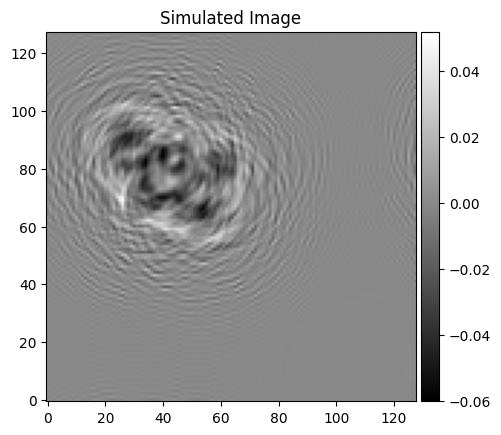

In [13]:
image = compute_image(
    new_parameters_file[0],
    constant_args=(potential, potential_integrator),
    per_particle_args=None,
)
plot_image(image, plt.figure(), plt.gca(), label="Simulated Image");

Now let's generate a particle stack using our function and the parameters we generated

In [ ]:
simulate_particle_stack(
    noiseless_particle_dataset,
    compute_image_fn=compute_image,
    constant_args=(potential, potential_integrator),
    per_particle_args=None,
    batch_size=10,  # this is for images generated in parallel
    images_per_file=50,
    overwrite=True,
)

## Simulating images with a noise distribution

In this example we will use a cryojax distribution to add the noise, but in practice you can do it however you want.

We need a different dataset, as we will save these images in a different folder

In [ ]:
# First load the starfile

path_to_mrc_files = "./outputs/relion_dataset_particles/with_noise"

noisy_particle_dataset = RelionParticleStackDataset(
    new_parameters_file,
    path_to_relion_project=path_to_mrc_files,
    mode="w",
    mrcfile_settings={"overwrite": True},  # customize your .mrcs !
)

the other parameters do not change, so there is no need to initialize them again.

We will follow a simular approach as before, except now we need a couple more arguments, and to create a cryojax distribution.

An image is defined as image = signal + noise. We will define a mask to normalize the signal such that it has mean 0 and variance 1. This will allows to easily set a signal-to-noise ratio (snr) by simply scaling the signal and setting the noise variance as 1. Let's see how to do this in code:

In [ ]:
from cryojax.distributions import IndependentGaussianPixels


def compute_image_with_noise(parameters, constant_args, per_particle_args):
    potential, potential_integrator, mask, snr = constant_args
    noise_key = per_particle_args  # jax random stuff

    structural_ensemble = cxs.SingleStructureEnsemble(potential, parameters["pose"])

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble, potential_integrator, parameters["transfer_theory"]
    )

    image_model = cxs.ContrastImageModel(
        parameters["instrument_config"], scattering_theory, mask=mask
    )

    distribution = IndependentGaussianPixels(
        image_model,
        variance=1.0,
        signal_scale_factor=jnp.sqrt(snr),
        normalizes_signal=True,
    )

    return distribution.sample(noise_key, applies_mask=False)

and generate an image from such distribution

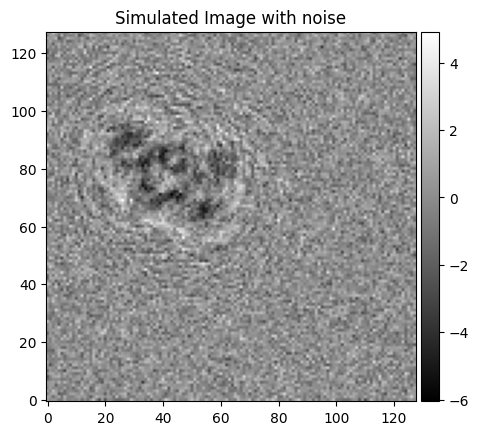

In [ ]:
key = jax.random.key(0)
mask = tf.CircularCosineMask(
    coordinate_grid=instrument_config.coordinate_grid_in_pixels,
    radius=instrument_config.shape[0] // 2,
    rolloff_width=0.0,
)
snr = 0.5

image_with_noise = compute_image_with_noise(
    new_parameters_file[0],
    (potential, potential_integrator, mask, snr),
    key,
)
plot_image(image_with_noise, plt.figure(), plt.gca(), label="Simulated Image with noise");

Lastly, let's generate a stack with noise

In [ ]:
key = jax.random.key(0)
noise_keys = jax.random.split(key, len(noisy_particle_dataset))

simulate_particle_stack(
    noisy_particle_dataset,
    compute_image_fn=compute_image_with_noise,
    constant_args=(potential, potential_integrator, mask, snr),
    per_particle_args=(noise_keys),
    batch_size=10,
    images_per_file=50,
    overwrite=True,
)

Now we can load our images using `RelionParticleStackDataset` objects

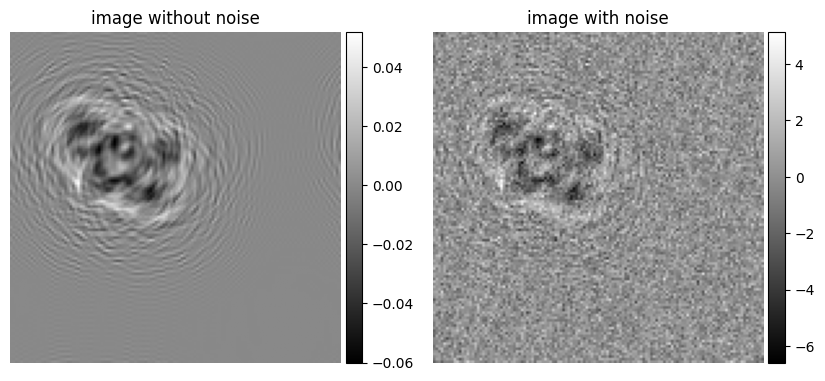

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for a in ax:
    a.set_axis_off()

im1 = plot_image(
    noiseless_particle_dataset[0]["images"],
    fig,
    ax[0],
    label="image without noise",
)

im2 = plot_image(
    noisy_particle_dataset[0]["images"],
    fig,
    ax[1],
    label="image with noise",
)